<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 17.3MB/s]


In [4]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [5]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [6]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 6033


In [7]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

In [8]:
for i in range(5):
 print(f'input: "{input_sentences[i]}"- output: "{output_sentences[i]}"- output_inputs: "{output_sentences_inputs[i]}"')

input: "hello "- output: "hi how are you  <eos>"- output_inputs: "<sos> hi how are you "
input: "hi how are you "- output: "not bad and you  <eos>"- output_inputs: "<sos> not bad and you "
input: "hi "- output: "hello  <eos>"- output_inputs: "<sos> hello "
input: "hi "- output: "hello  <eos>"- output_inputs: "<sos> hello "
input: "hi "- output: "hello how are you today  <eos>"- output_inputs: "<sos> hello how are you today "


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [9]:
# Establecer el límite máximo de palabras únicas en el vocabulario.
# Un vocabulario más grande puede abarcar más palabras, pero aumenta la complejidad.
MAX_VOCAB_SIZE = 8000

In [10]:
from keras.preprocessing.text import Tokenizer

# Inicializar el tokenizer de Keras para procesar el texto de entrada
# num_words especifica el número máximo de palabras más frecuentes a considerar
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

# Ajustar el tokenizer a las sentencias de entrada y convertirlas a secuencias de enteros
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

# Crear un mapeo de palabra a índice para el vocabulario
word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

# Determinar la longitud de la sentencia más larga en las secuencias de entrada
max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1799
Sentencia de entrada más larga: 9


In [11]:
# Inicializar el tokenizer para procesar las sentencias de salida
# Se excluyen '\t' y '\n' como filtros para mantenerlos en las secuencias
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='\t\n')

# Ajustar el tokenizer a las sentencias de salida
output_tokenizer.fit_on_texts(output_sentences + output_sentences_inputs)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

# Crear un mapeo de palabra a índice para el vocabulario de salida
word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

# Determinar el número de palabras en el vocabulario de salida, considerando un token adicional para palabras desconocidas
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE)

# Calcular la longitud de la sentencia de salida más larga
max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1806
Sentencia de salida más larga: 10


In [12]:
# Establecer la longitud máxima para las secuencias de entrada.
# Esto define el número máximo de palabras que se considerarán en cada secuencia de entrada.
max_input_len = 10

In [13]:
# Imprimir la cantidad total de filas (secuencias) en el dataset
print("Cantidad de rows del dataset:", len(input_integer_seq))

# Crear secuencias de entrada para el codificador, con un relleno para alcanzar la longitud máxima definida
# Esto asegura que todas las secuencias tengan la misma longitud para el modelo
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

# Preparar las secuencias de entrada para el decodificador, con relleno al final para igualar la longitud máxima
# Se busca uniformidad en la longitud de las secuencias para el procesamiento del modelo
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 6033
encoder_input_sequences shape: (6033, 10)
decoder_input_sequences shape: (6033, 10)


In [14]:
from keras.utils import to_categorical

# Preparar las secuencias de salida del decodificador, aplicando relleno al final para uniformidad de longitud
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')

# Convertir las secuencias de salida a representaciones categóricas (one-hot encoding)
# Esto es útil para la clasificación multiclase en el modelo de aprendizaje profundo
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

# Imprimir la forma del tensor de objetivos del decodificador para verificar su estructura
print("Forma de los objetivos del decodificador (decoder_targets):", decoder_targets.shape)

Forma de los objetivos del decodificador (decoder_targets): (6033, 10, 1807)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [15]:
import os
import gdown

# Verificar si el archivo de embeddings 'fasttext.pkl' ya existe en el directorio actual
# Si no existe, se descargará desde un enlace de Google Drive
if os.access('fasttext.pkl', os.F_OK) is False:
    # URL de descarga para el archivo de embeddings desde Google Drive
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'

    # Descargar el archivo utilizando la biblioteca gdown
    gdown.download(url, output, quiet=False)
else:
    # Imprimir un mensaje si el archivo de embeddings ya está presente
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t
To: /content/fasttext.pkl
100%|██████████| 2.88G/2.88G [00:43<00:00, 65.6MB/s]


In [16]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle
import numpy as np

# Definición de la clase WordsEmbeddings para manejar embeddings de palabras
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # Cargar los embeddings desde un archivo pickle o convertirlos desde un archivo de texto
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings

        # Construir los diccionarios para mapear palabras a índices y viceversa
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        """Obtiene los embeddings para una lista de palabras."""
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        """Convierte palabras en sus índices correspondientes en el vocabulario."""
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        """Convierte índices en palabras correspondientes."""
        return np.array([self.idx2word.get(idx, 'UNK') for idx in idxs])

    def load_model_from_pickle(self):
        """Carga el modelo de embeddings desde un archivo pickle."""
        self.logger.debug('Cargando embeddings desde el pickle {}'.format(self.PKL_PATH))
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('Embeddings cargados')
        return embeddings

    def convert_model_to_pickle(self):
        """Convierte y carga los embeddings desde un archivo de texto a pickle."""
        self.logger.debug('Convirtiendo y cargando los embeddings desde el archivo {}'.format(self.WORD_TO_VEC_MODEL_TXT_PATH))
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)

        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES)
            embeddings = np.fromiter(embeddings_gen, structure)

        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure)

        embeddings = np.concatenate([embeddings, null_embedding])

        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('Embeddings cargados')
        return embeddings

# Subclases para diferentes tipos de embeddings como Glove y Fasttext
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [17]:
# Inicializar la instancia de FasttextEmbeddings.
# Se configura para utilizar embeddings Fasttext de 300 dimensiones.
model_embeddings = FasttextEmbeddings()

In [18]:
# Crear la matriz de embeddings para las secuencias en inglés

embed_dim = model_embeddings.N_FEATURES  # Dimensiones de los embeddings
words_not_found = []  # Lista para almacenar palabras no encontradas en los embeddings

# word_index proviene del tokenizer
# nb_words es el tamaño más pequeño entre el tamaño máximo del vocabulario y el número de palabras únicas
nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs))

# Inicializar la matriz de embeddings con ceros
embedding_matrix = np.zeros((nb_words, embed_dim))

# Llenar la matriz de embeddings con los vectores correspondientes de cada palabra
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue  # Ignorar palabras que exceden el tamaño del vocabulario
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # Asignar el vector de embedding a la matriz
        embedding_matrix[i] = embedding_vector
    else:
        # Las palabras no encontradas en los embeddings se mantienen como vectores de cero
        words_not_found.append(word)

# Imprimir la cantidad de palabras cuyos embeddings no se encontraron (vectores de cero)
print('Cantidad de palabras cuyos embeddings no se encontraron:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

Cantidad de palabras cuyos embeddings no se encontraron: 1


In [19]:
# Dimensión de los embeddings de la secuencia en inglés
embedding_matrix.shape

(1799, 300)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Embedding

# Definir el número de unidades para las capas LSTM
n_units = 1024

# Definir el codificador (encoder) para el entrenamiento
encoder_inputs = Input(shape=(max_input_len))

# Capa de embedding para el codificador
# Utiliza la matriz de embeddings previamente creada y es marcada como no entrenable
encoder_embedding_layer = Embedding(
          input_dim=nb_words,           # Número de palabras definidas en el Tokenizador
          output_dim=embed_dim,         # Dimensión de los embeddings utilizados
          input_length=max_input_len,   # Tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],   # Matriz de embeddings
          trainable=False)              # Marcar como capa no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

# Definir la capa LSTM del codificador
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# Definir el decodificador (decoder) para el entrenamiento
decoder_inputs = Input(shape=(max_out_len))

# Capa de embedding para el decodificador
# Similar a la del codificador, pero ajustada para las secuencias de salida
decoder_embedding_layer = Embedding(
          input_dim=nb_words,           # Número de palabras definidas en el Tokenizador
          output_dim=embed_dim,         # Dimensión de los embeddings utilizados
          input_length=max_out_len,     # Tamaño máximo de la secuencia de salida
          weights=[embedding_matrix],   # Matriz de embeddings
          trainable=False)              # Marcar como capa no entrenable

decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

# Definir la capa LSTM del decodificador
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Capa densa para clasificar la salida de la secuencia
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Compilar el modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

# Mostrar un resumen del modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 10, 300)              539700    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 300)              539700    ['input_2[0][0]']             
                                                                                              

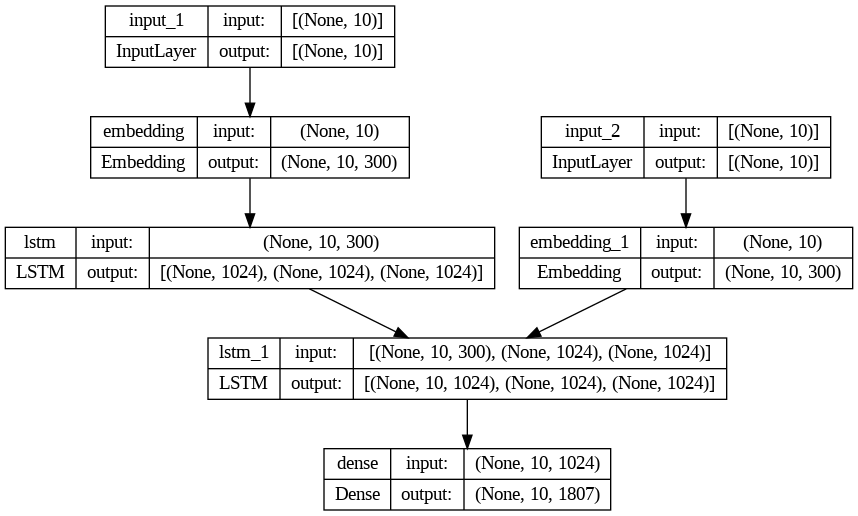

In [21]:
from keras.utils import plot_model

# Generar y guardar una visualización gráfica del modelo completo (encoder + decoder)
# Esto ayuda a entender la arquitectura del modelo, incluyendo las formas de los datos en cada capa y los nombres de las capas
# Es útil para depurar, entender y compartir la estructura del modelo con otros
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

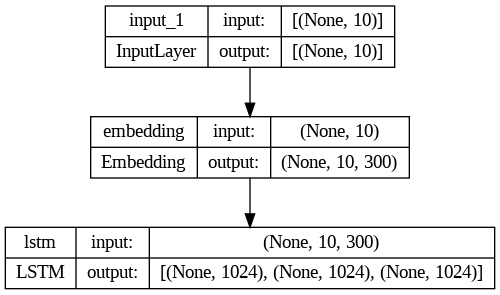

In [22]:
# Crear el modelo para solo el encoder
# Este modelo se usará para la inferencia, donde solo se necesita el estado del encoder
encoder_model = Model(encoder_inputs, encoder_states)

# Generar y guardar una visualización gráfica del modelo del encoder
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

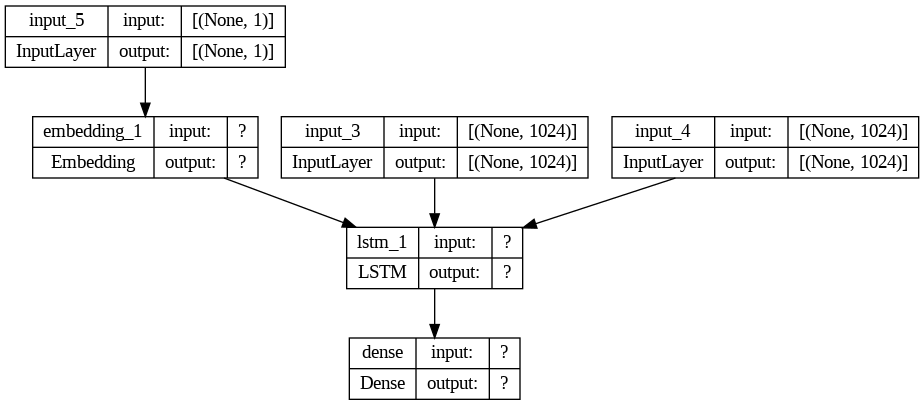

In [23]:
# Crear el modelo para solo el decodificador, que se utilizará para la inferencia
# Este modelo facilita la generación de la secuencia de salida palabra por palabra

# Definir las entradas de estado para el decodificador
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Modificar la capa de embedding del decodificador para aceptar una sola palabra a la vez
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

# Definir la arquitectura del decodificador para la inferencia
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

# Compilar el modelo del decodificador
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

# Generar y guardar una visualización gráfica del modelo del decodificador
# Esto ayuda a comprender y depurar la arquitectura del decodificador,
# mostrando las formas de los datos y los nombres de las capas
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
# Entrenar el modelo
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=50,
    validation_split=0.2)

Epoch 1/50
151/151 [==============================] - 13s 32ms/step - loss: 2.1267 - accuracy: 0.6391 - val_loss: 1.8956 - val_accuracy: 0.6804
Epoch 2/50
151/151 [==============================] - 3s 23ms/step - loss: 1.5560 - accuracy: 0.7151 - val_loss: 1.7997 - val_accuracy: 0.6968
Epoch 3/50
151/151 [==============================] - 3s 23ms/step - loss: 1.4073 - accuracy: 0.7300 - val_loss: 1.7588 - val_accuracy: 0.7022
Epoch 4/50
151/151 [==============================] - 3s 22ms/step - loss: 1.2976 - accuracy: 0.7405 - val_loss: 1.7473 - val_accuracy: 0.7087
Epoch 5/50
151/151 [==============================] - 3s 22ms/step - loss: 1.2050 - accuracy: 0.7480 - val_loss: 1.7559 - val_accuracy: 0.7079
Epoch 6/50
151/151 [==============================] - 3s 23ms/step - loss: 1.1179 - accuracy: 0.7545 - val_loss: 1.7575 - val_accuracy: 0.7123
Epoch 7/50
151/151 [==============================] - 3s 21ms/step - loss: 1.0328 - accuracy: 0.7640 - val_loss: 1.7947 - val_accuracy: 0.711

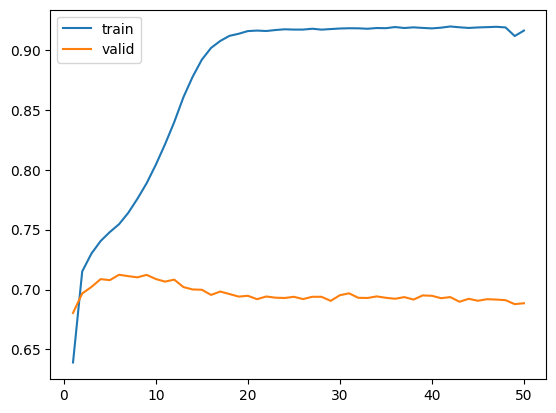

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar el progreso del entrenamiento a través de las épocas

# Contar el número de épocas
epoch_count = range(1, len(hist.history['accuracy']) + 1)

# Graficar la precisión para los conjuntos de entrenamiento y validación
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')

# Mostrar el gráfico
plt.show()

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [26]:
# Armar los conversores de índice a palabra:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [27]:
def response(input_seq):
    # Se transforma la sequencia de entrada a los estados "h" y "c" de la LSTM
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder con "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']  # Use the token for start of sentence

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']  # Use the token for end of sentence

    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentence" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [45]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
bot_response = response(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', bot_response)

1/1 [==============================] - 0s 38ms/step
-
Input: hi
Response: hello how are you


In [49]:
def generate_response(input_text):
    # Convertir el texto de entrada en una secuencia de enteros
    integer_seq = input_tokenizer.texts_to_sequences([input_text])[0]
    print("Input tokenizado:", integer_seq)

    # Realizar el padding de la secuencia
    encoder_input_seq = pad_sequences([integer_seq], maxlen=max_input_len)
    print("Input con padding:", encoder_input_seq)

    # Generar la respuesta
    response_text = response(encoder_input_seq)
    return response_text

In [50]:
input_test = "Where are you from?"
print('Input:', input_test)
bot_response = generate_response(input_test)
print('Response:', bot_response)

Input: Where are you from?
Input tokenizado: [52, 7, 2, 39]
Input con padding: [[ 0  0  0  0  0  0 52  7  2 39]]
1/1 [==============================] - 0s 20ms/step
Response: i am from the united states


In [46]:
input_test = "Do you read?"
print('Input:', input_test)
bot_response = generate_response(input_test)
print('Response:', bot_response)

Input: Do you read?
Tokenized input: [3, 2, 23]
Padded input: [[ 0  0  0  0  0  0  0  3  2 23]]
1/1 [==============================] - 0s 30ms/step
Response: yes i do


In [47]:
input_test = "Do you have any pet?"
print('Input:', input_test)
bot_response = generate_response(input_test)
print('Response:', bot_response)

Input: Do you have any pet?
Tokenized input: [3, 2, 16, 31, 252]
Padded input: [[  0   0   0   0   0   3   2  16  31 252]]
1/1 [==============================] - 0s 21ms/step
Response: no and you


In [62]:
from ipywidgets import widgets
from IPython.display import display, clear_output
import contextlib
import io

def on_send_button_clicked(_):
    # Cuando se hace clic en el botón de enviar
    user_input = text_input.value

    # Procesar la entrada del usuario (tokenización y padding)
    input_seq = input_tokenizer.texts_to_sequences([user_input])  # Tokenizar
    input_seq = pad_sequences(input_seq, maxlen=max_input_len)  # Aplicar padding

    # Suprimir los mensajes de progreso de la predicción
    with contextlib.redirect_stdout(io.StringIO()):
        bot_response = response(input_seq)

    # Limpiar la entrada actual
    text_input.value = ''

    # Mostrar la conversación
    print(f"Tú: {user_input}")
    print(f"Bot: {bot_response}")

# Crear widget de entrada de texto
text_input = widgets.Text(description='Usuario:', placeholder='Escribe algo...')
send_button = widgets.Button(description='Enviar')
send_button.on_click(on_send_button_clicked)

# Mostrar los widgets
display(text_input, send_button)

Text(value='', description='Usuario:', placeholder='Escribe algo...')

Button(description='Enviar', style=ButtonStyle())

Tú: hi
Bot: hello how are you
Tú: im good, how about you?
Bot: i m great thank you
Tú: how was your day
Bot: i am fine and you
